# 3. Configurable Scenario Generation

In this notebook, we demonstrate the capabilities of the configurable scenario generation of BARK. First, we clarify what a BARK scenario is, to then describe how the configurable scenario generation allows flexible, extensible creation of a variety of scenario types.

## 3.1 BARK Scenarios

A BARK scenario contains a list of agents
with their initial states, behavior, execution and dynamic
models as well as a goal definition for each agent. Further,
it contains a map file in the OpenDrive format. To support
behavior benchmarking, each scenario specifies which agent
is considered as the ‘controlled’ agent during the simulation.
A BARK scenario does not explicitly specify how agents
will behave over time, e.g. using predefined maneuvers or
trajectories. 

A BARK scenario thus uses the following implementation:

In [3]:
class Scenario:
  def __init__(self,
               agent_list=None,
               eval_agent_ids=None,
               map_file_name=None,
               json_params=None,
               map_interface=None):
    self._agent_list = agent_list or []
    self._eval_agent_ids = eval_agent_ids or []
    self._map_file_name = map_file_name
    self._json_params = json_params
    self._map_interface = map_interface

The scenario class separately persists agents and the map file name. When multiple scenarios are based on the same map file, this then avoids serialization of processed map information in all the scenarios. In contrast, agents are fully serialized via python pickling. For this, the C++ agent class and all members, e.g behavior models suport python serialization.

Before starting to run a scenario. The benchmark runner then calls `_build_world_state` to create the world state used in a simulation run:

In [4]:
  def _build_world_state(self):
    param_server = ParameterServer(json=self._json_params)
    world = World(param_server)
    if self._map_interface is None:
      world = self.SetupMap(world, self._map_file_name)
    else:
      world.SetMap(self._map_interface)
    for agent in self._agent_list:
      agent.GenerateRoadCorridor(self._map_interface)
      world.AddAgent(agent)
    return world

## 3.2 BARK Scenario Generation

Based on the scenario definition, we define a Scenario Generation base class being responsible to create a list of scenario and managing saving, loading of scenario sets and getting of scenarios. The simplified structure of BARK's base scenario generation is:

In [5]:
class ScenarioGeneration:
  def __init__(self, params=None, num_scenarios=None, random_seed=1000):
    self._params = params
    self._current_scenario_idx = 0
    self._random_seed = random_seed

    self._scenario_list = self.create_scenarios(params, num_scenarios)

  def get_scenario(self, idx):
    return self._scenario_list[idx].copy()

  def dump_scenario_list(self, filename):
    with open(filename, "wb") as file:
      # print("SAVE PATH:", os.path.abspath(filename))
      pickle.dump(self._scenario_list, file)

  def load_scenario_list(self, filename):
    with open(filename, "rb") as file:
      self._scenario_list = pickle.load(file)

This base class allows to easily create new scenario generations while enabling easy integration in to BARK's benchmarking and ML training platforms which use these common interfaces.

Let's have a look how what the configurable scenario generation provides.

## 3.3 Concept of Configurable Scenario Generation

Though, new scenarios generations are supported with the common interface, we require a modularized perspective on the set of features characterizing a scenario. For instance, we want to configure initial states of agents independently of behavior models or goal configurations. To achieve this, we must ensure that configuration options for one set of features can easily be combined with other sets of features. The configurable scenario generation implements this requirement.

The fundamental building blocks of a scenario in the configurable scenario generation are source sink pairs. A source sink pair defines a road corridor in the map. It is specified with either a pair of OpenDrive Road Ids or a pair of X/Y Points. 

For each source sink pair, multiple config readers are responsible to create the features within this sink source pair. Config readers exist for each relevant property in a scenario which are processed for a source sinks pair in a specific order. Information from config reader is passed to the next readers. We distinguish between fundamdental information to build a scenario which must be returned by a config reader and optional information which may be passed and could be incorporated by subsequent readers. The information flow to create the agents in a **single** source sink config is as follows 

1. ConfigReaderAgentStatesAndGeometries: 
    - Retrieves: Road corridor of this source sink
    - Must return: list of agent states and a list of agent shapes
    - Optional return: e.g. list of agent ids, lane positions,
2. ConfigBehaviorModels:
    - Retrieves: Road corridor of this source sink, agent state list, collected optional returns
    - Must return: list of behavior models for each agent in agent state list
    - Optional return: e.g. list of types of behavior models
3. ConfigExecutionModels:
    - Retrieves: Road corridor of this source sink, agent state list, collected optional returns
    - Must return: list of execution models for each agent in agent state list
    - Optional return: e.g. list of types of execution models
4. ConfigDynamicModels:
    - Retrieves: Road corridor of this source sink, agent state list, collected optional returns
    - Must return: list of dynamic models for each agent in agent state list
    - Optional return: e.g. list of types of dynamic models
5. ConfigControlledAgents:
    - Retrieves: Road corridor of this source sink, agent state list, collected optional returns
    - Must return: List of size agent state list with True or False indicating if agent is controlled in a     benchmarking run or not
    - Optional return: normally nothing
6. ConfigGoalDefinitions:
    - Retrieves: Road corridor of this source sink, agent state list, list of controlled_agent_ids, collected optional returns
    - Must return: List of goal definitions one for each agent in agent state list
    - Optional return: normally nothing
    
Returns are collected and finally the agents for the source sink config are created. Then, the chain is run for the next source sink config. The interfaces of all config reader types are implemented in 
[config_readers_interfaces.py](https://github.com/bark-simulator/bark/blob/master/bark/runtime/scenario/scenario_generation/config_readers/config_readers_interfaces.py)


## 3.4 Understanding Parameter Files

Let's have a look at the default parameter file of the configurable scenario generation to better understand this concept:

In [1]:
import config_notebook
import json
from bark.runtime.scenario.scenario_generation.configurable_scenario_generation import ConfigurableScenarioGeneration
from bark.runtime.commons.parameters import ParameterServer
import os

params = ParameterServer()

scenario_generation = ConfigurableScenarioGeneration(num_scenarios = 5, params = params)

params.Save("default_params.json")
print("\n\n ------ Scenario Default Parameters ---------")
print(json.dumps(params.ConvertToDict(), indent=4))

Changing to bark root /home/julo/.cache/bazel/_bazel_julo/6148542f54f1c4e49e4ced7294c97977/execroot/bark_project/bazel-out/k8-fastbuild/bin/docs/tutorials/run.runfiles/bark_project
Writing parameters to /home/julo/.cache/bazel/_bazel_julo/6148542f54f1c4e49e4ced7294c97977/execroot/bark_project/bazel-out/k8-fastbuild/bin/docs/tutorials/run.runfiles/bark_project/default_params.json


 ------ Scenario Default Parameters ---------
{
    "Scenario": {
        "Generation": {
            "ConfigurableScenarioGeneration": {
                "MapFilename": "bark/runtime/tests/data/city_highway_straight.xodr",
                "SinksSources": [
                    {
                        "SourceSink": [
                            [
                                5111.626,
                                5006.8305
                            ],
                            [
                                5110.789,
                                5193.1725
                            ]
        

In the default configuration, we have two sources and sinks specified. One for the left lane of the road corridor on an highway, one for the right lane. We use the config reader type UniformVehicleDistribution for  ConfigAgentStatesGeometries. There, we can specify vehicle distance ranges and ranges of initial velocity. As behavior model config, we use FixedBehaviorType, where one type of behavior model with its parameters is specified. Goal definition uses config reader FixedGoalTypes enabling separate specification of goal definitions for controlled and non-controlled agents. It uses a FrenetGoalType with a geometric goal region around the centerline of the goal lane. The range of this region is specified via parameter LongitudinalRange. With BARKs runtime, we can have a look through the sceanarios created with the default parameter config:

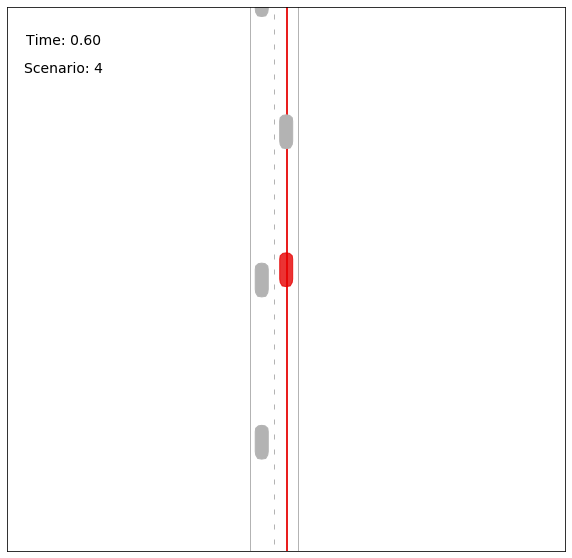

In [2]:
from IPython import display

from bark.runtime.viewer.matplotlib_viewer import MPViewer
from bark.runtime.runtime import Runtime
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
viewer = MPViewer(
  params=params,
  y_length = 80,
  enforce_y_length=True,
  enforce_x_length=False,
  follow_agent_id=True,
  axis=plt.gca())


num_scenarios_to_show = 5
num_steps_per_scenario = 4
step_time = 0.2

for _ in range(0, num_scenarios_to_show):
    scenario, idx = scenario_generation.get_next_scenario()
    world = scenario.GetWorldState()
    for _ in range(0, num_steps_per_scenario): 
      viewer.drawWorld(world, eval_agent_ids=scenario._eval_agent_ids, scenario_idx=idx )
      display.clear_output(wait=True)
      display.display(viewer.axes.get_figure())
      world.Step(step_time)
      viewer.clear()

We see the controlled agent in red and its goal region on the right lane. We now tune the parameters that the controlled agents goal is on the left lane. Additionally, we want to create more dense traffic on the left lane to make the lane change scenario harder. We decrease the range for sampling distances and velocity. Further and recreate the scenarios:

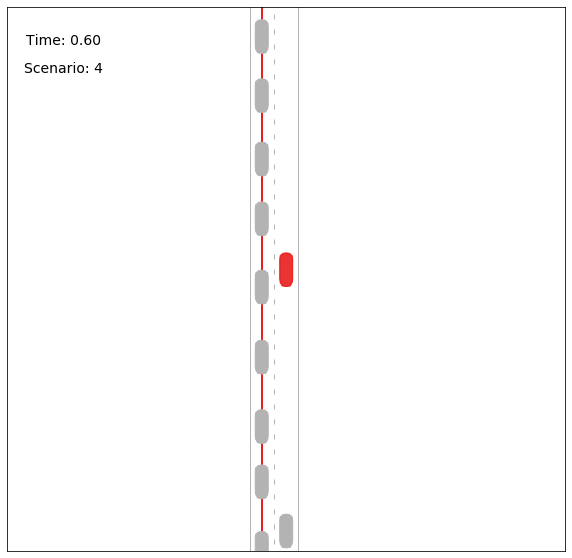

In [8]:
params_src_sink_right = params["Scenario"]["Generation"]["ConfigurableScenarioGeneration"]["SinksSources"][1]
params_src_sink_right["ConfigGoalDefinitions"]["GoalTypeControlled"] = "LaneChangeLeft"

params_src_sink_left = params["Scenario"]["Generation"]["ConfigurableScenarioGeneration"]["SinksSources"][0]
params_src_sink_left["ConfigAgentStatesGeometries"]["VehicleDistanceRange"] = [3, 6]
params_src_sink_left["ConfigAgentStatesGeometries"]["OtherVehicleVelocityRange"] = [3, 6]

scenario_generation = ConfigurableScenarioGeneration(num_scenarios = 5, params = params)

num_scenarios_to_show = 5
num_steps_per_scenario = 4
step_time = 0.2

for _ in range(0, num_scenarios_to_show):
    scenario, idx = scenario_generation.get_next_scenario()
    world = scenario.GetWorldState()
    for _ in range(0, num_steps_per_scenario): 
      viewer.drawWorld(world, eval_agent_ids=scenario._eval_agent_ids, scenario_idx=idx )
      display.clear_output(wait=True)
      display.display(viewer.axes.get_figure())
      world.Step(step_time)
      viewer.clear()

## 3.5 Conflict Resolution between Source Sink Configs

As discussed, the config reader chain is processed separately for each source sink config. To avoid **physical** overlapping of initial agent states, we can use the conflict resolution specification between source and sinks. 

Especially in intersection scearions overlaps occur within the intersection or when building scenarios where vehicles should either turn left or go straight.

In the following, we show an intersection scenario and explaing the conflict resolution.

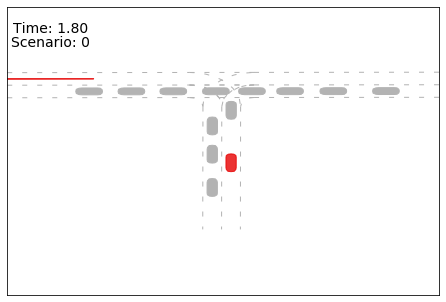

In [7]:
scenario_param_file ="intersection_configurable.json" # must be within examples params folder
param_server = ParameterServer(filename= os.path.join("examples/params/",scenario_param_file))
scenario_generation = ConfigurableScenarioGeneration(num_scenarios=20, random_seed=0, params=param_server)

viewer = MPViewer(params=param_server, use_world_bounds=True)
sim_step_time = param_server["simulation"]["step_time",
                                           "Step-time used in simulation",
                                           0.2]
sim_real_time_factor = param_server["simulation"]["real_time_factor",
                                                  "execution in real-time or faster", 1]
scenario, idx = scenario_generation.get_next_scenario()


num_scenarios_to_show = 20
num_steps_per_scenario = 20
step_time = 0.2

for _ in range(0, num_scenarios_to_show):
    scenario, idx = scenario_generation.get_next_scenario()
    world = scenario.get_world_state()
    for _ in range(0, num_steps_per_scenario): 
      viewer.drawWorld(world, eval_agent_ids=scenario._eval_agent_ids, scenario_idx=idx )
      display.clear_output(wait=True)
      display.display(viewer.axes.get_figure())
      world.Step(step_time)
      viewer.clear()

For this scenario, we specified three source sink configurations for the west->east corridor, the south->west corridor and east->west corridor. In the scenario generation param file, we specified how overlaps should be resolved as follows:

In [8]:
print(json.dumps(param_server["Scenario"]["Generation"] \
                     ["ConfigurableScenarioGeneration"]["ConflictResolution"].ConvertToDict(), indent=4))

{
    "west_south/west_east": [
        0.45,
        0.55
    ],
    "south_west/west_east": [
        0.5,
        0.5
    ],
    "south_west/west_south": [
        0.5,
        0.5
    ]
}


The names used correspond to the source sink description given in the definition of the respective source sink config. The numbers specify with what probability an overlap is resolved using a vehicle from one or the other corridor. We continue with writing our own config reader.

## 3.5 Writing an own config reader to sample behavior type
There is a number of config readers defined in [config_readers](https://github.com/bark-simulator/bark/tree/master/bark/runtime/scenario/scenario_generation/config_readers) and we plan to extend this set further in the future. 

In this section, we demonstrate how to write your own config reader, writing a config reader for behavior model sampling. But the process can be easily applied to the other config reader types as well.

The config reader shall randomly sample behavior types among a list of specified behavior types. We reimplement the interface of ConfigReaderBehaviorModels as follows

In [7]:
from bark.runtime.scenario.scenario_generation.config_readers.config_readers_interfaces import ConfigReaderBehaviorModels
from bark.core.models.behavior import *
from bark.runtime.commons.parameters import ParameterServer

class SampleBehaviorType(ConfigReaderBehaviorModels):
  def __init__(self, random_state):
    super().__init__(random_state)
    self.param_servers = []

  def create_from_config(self, config_param_object, road_corridor, agent_states,  **kwargs):
    model_types = config_param_object["ModelTypesList", "Type of behavior model" \
                "used for all vehicles", ["BehaviorIDMClassic", "BehaviorMobil"]]
    model_params = config_param_object.AddChild("ModelParams")
    # ----- DEFAULT PARAMETER HANDLING
    # based on types retrieve default params which are maintained as scenario defaults
    for model_type in model_types:
        behavior_params = model_params.AddChild(model_type)
        _, _ = self.model_from_model_type(model_type, behavior_params)
        #param server must be persisted for each behavior to enable serialization of parameters
        

    #------ BEHAVIOR MODEL SAMPLING
    behavior_models = []
    behavior_model_types = []
    for _ in agent_states:
        model_idx = self.random_state.randint(low=0, high=len(model_types), size=None) 
        model_type = model_types[model_idx]
        model_type_params = model_params.AddChild(model_type)
        params = ParameterServer()
        bark_model, params = self.model_from_model_type(model_type, model_type_params)
        self.param_servers.append(model_type_params) 
        behavior_models.append(bark_model)
        behavior_model_types.append(model_type)
    return behavior_models, {"behavior_model_types" : behavior_model_types}, config_param_object

  def model_from_model_type(self, model_type, params):
    bark_model = eval("{}(params)".format(model_type))    
    return bark_model, params

  def get_param_servers(self):
    return self.param_servers

The main functionality is covered in `create_from_config(self, config_param_object, road_corridor, agent_states,  **kwargs)`. Here, we first read a list of behavior types from the parameter server and read it out the default parameters of these model types. Then, we use the global random seed state managed by the scenario generation to sample the behavior types. Note that the parameter servers of objects must be persisted to allow for serialization of behavior models. This class definition must be found by ConfigurableScenarioGeneration. We put it into the [behavior_model_config_readers.py](https://github.com/bark-simulator/bark/blob/master/bark/runtime/scenario/scenario_generation/config_readers/behavior_model_config_readers.py) containing the already existing ConfigReaderBehaviorModels.

Now, we use this config to randomly sample Mobil and IDM models on the right highway lane. We can first set the type of ConfigBehaviorModels to our new definition. By rerunning the scenario generation, all **default parameters are automatically extracted**. Afterwards, we can finetune these parameters. First let's specify the new config type and extract the defaults. To specify a config type simply use the name given to the config reader class. We now have the following initial source sink config and running the scenario generation gives as the default params. These can of course be customized as desired

In [8]:
sink_source_dict = [{
      "SourceSink": [[5111.626, 5006.8305],  [5110.789, 5193.1725] ],
      "Description": "left_lane",
      "ConfigAgentStatesGeometries": {"Type": "UniformVehicleDistribution", "LanePositions": [0]},
      "ConfigBehaviorModels": {"Type": "FixedBehaviorType"},
      "ConfigExecutionModels": {"Type": "FixedExecutionType"},
      "ConfigDynamicModels": {"Type": "FixedDynamicType"},
      "ConfigGoalDefinitions": {"Type": "FixedGoalTypes"},
      "ConfigControlledAgents": {"Type": "NoneControlled"},
      "AgentParams" : {}
    },
    {
      "SourceSink": [[5111.626, 5006.8305],  [5110.789, 5193.1725] ],
      "Description": "right_lane",
      "ConfigAgentStatesGeometries": {"Type": "UniformVehicleDistribution", "LanePositions": [1]},
      "ConfigBehaviorModels": {"Type": "SampleBehaviorType"},
      "ConfigExecutionModels": {"Type": "FixedExecutionType"},
      "ConfigDynamicModels": {"Type": "FixedDynamicType"},
      "ConfigGoalDefinitions": {"Type": "FixedGoalTypes"},
      "ConfigControlledAgents": {"Type": "RandomSingleAgent"},
      "AgentParams" : {}
    }]
params = ParameterServer()
params["World"]["remove_agents_out_of_map"] = True
params["Scenario"]["Generation"]["ConfigurableScenarioGeneration"]["SinksSources"] = sink_source_dict
scenario_generation = ConfigurableScenarioGeneration(num_scenarios=2,params=params)

print("\n\n ------ ConfigBehaviorModels Default Parameters ---------")
print(json.dumps(params["Scenario"]["Generation"]["ConfigurableScenarioGeneration"]["SinksSources"][1]["ConfigBehaviorModels"], indent=4))



 ------ ConfigBehaviorModels Default Parameters ---------
{
    "Type": "SampleBehaviorType",
    "ModelTypesList": [
        "BehaviorIDMClassic",
        "BehaviorMobil"
    ],
    "ModelParams": {
        "BehaviorIDMClassic": {
            "BehaviorIDMClassic": {
                "MinimumSpacing": 2.0,
                "DesiredTimeHeadway": 1.5,
                "MaxAcceleration": 1.7000000476837158,
                "AccelerationLowerBound": -5.0,
                "AccelerationUpperBound": 8.0,
                "DesiredVelocity": 15.0,
                "ComfortableBrakingAcceleration": 1.6699999570846558,
                "MinVelocity": 0.0,
                "MaxVelocity": 50.0,
                "Exponent": 4
            }
        },
        "BehaviorMobil": {
            "BehaviorMobil": {
                "BehaviorIDMClassic": {
                    "MinimumSpacing": 2.0,
                    "DesiredTimeHeadway": 1.5,
                    "MaxAcceleration": 1.7000000476837158,
            

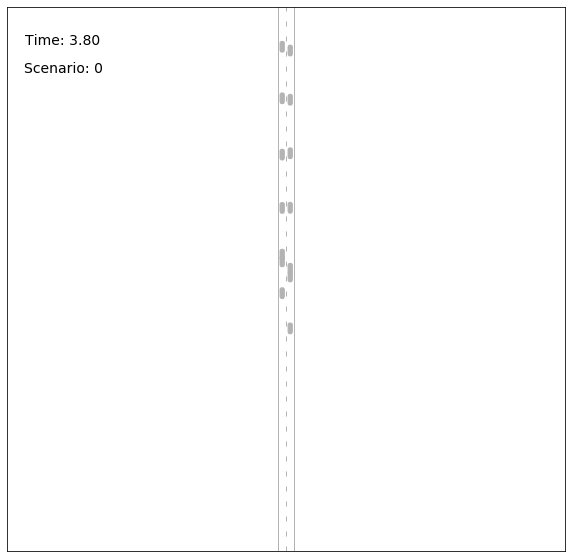

In [9]:
plt.figure(figsize=(10, 10))
viewer = MPViewer(
  params=params,
  y_length = 80,
  enforce_y_length=True,
  enforce_x_length=False,
  use_world_bounds=True,
  axis=plt.gca())

num_scenarios_to_show = 5
num_steps_per_scenario = 20
step_time = 0.2

for _ in range(0, num_scenarios_to_show):
    scenario, idx = scenario_generation.get_next_scenario()
    world = scenario.GetWorldState()
    for _ in range(0, num_steps_per_scenario): 
      viewer.drawWorld(world, eval_agent_ids=scenario._eval_agent_ids, scenario_idx=idx )
      display.clear_output(wait=True)
      display.display(viewer.axes.get_figure())
      world.Step(step_time)
      viewer.clear()